In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import os
import glob

In [2]:
RESULTS_PATH = '/raid/rustam/danil/beams_loss_test'
MEAN_TRAIN = 'mean_train'
MEAN_VAL = 'mean_val'
ACCURACY_FILE_NAME = 'accuracy.npy'
VAL_ACCURACY_FILE_NAME = 'val_accuracy.npy'
CONFIG_FILE_NAME = 'config_data.json'

CONFIG = 'config'
L1_N = 'L1'
L2_N = 'L2'
L1_L2_N = 'L1L2'
LABEL_SMOOTHING = 'LB'

MAGIC_SHIFT = 10.5

CONFIG_TO_RESULT = {}

In [3]:
def smooth_values(values: np.ndarray, decay=0.6):
    def calc_new_value(old, new):
        return old * decay + new * (1 - decay)
    new_values = [0.0]
    for val in values:
        new_values.append(calc_new_value(new_values[-1], val))
    return new_values

In [4]:
for single_net_folder in glob.glob(os.path.join(RESULTS_PATH, 'exp_*')):
    with open(f'{single_net_folder}/{CONFIG_FILE_NAME}', 'r') as fp:
        config_data = json.load(fp)

    arch_name = single_net_folder.split('/')[-1].split('_')[-1]
    all_experiments_folders = glob.glob(os.path.join(single_net_folder, '*_exp'))
    all_accuracy = np.stack([
        np.load(os.path.join(single_exp_folder, ACCURACY_FILE_NAME))
        for single_exp_folder in all_experiments_folders
    ])
    all_val_accuracy = np.stack([
        np.load(os.path.join(single_exp_folder, VAL_ACCURACY_FILE_NAME))
        for single_exp_folder in all_experiments_folders
    ])

    mean_per_epoch_accuracy = all_accuracy.mean(axis=0)
    mean_per_epoch_val_accuracy = all_val_accuracy.mean(axis=0)
    
    reg_config = config_data['reg']
    if reg_config:
        l1_config = reg_config.get('l1', False)
        l2_config = reg_config.get('l2', False)
        if l1_config and l2_config:
            l1_config = False
            l2_config = False
            l1l2_config = True
        else:  
            l1l2_config = False
    else:
        l1_config = False
        l2_config = False
        l1l2_config = False
    
    CONFIG_TO_RESULT[arch_name] = {
        MEAN_TRAIN: mean_per_epoch_accuracy,
        MEAN_VAL: mean_per_epoch_val_accuracy,
        CONFIG: {
            L1_N: l1_config,
            L2_N: l2_config,
            L1_L2_N: l1l2_config,
            LABEL_SMOOTHING: config_data['label_smoothing'] > 1e-3,
        }
    }

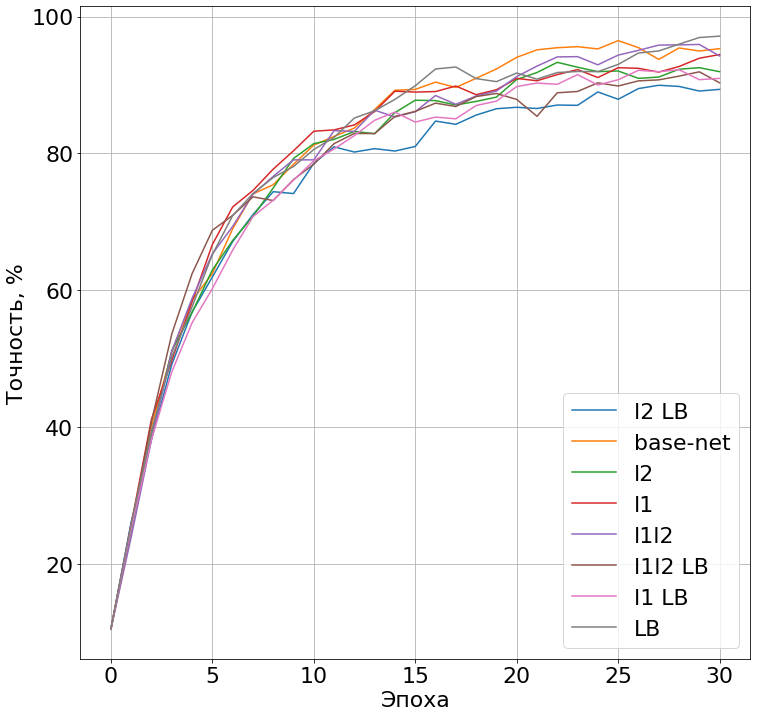

In [7]:
legends = []
fig = plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size': 22})

for net_name, result_dict in CONFIG_TO_RESULT.items():
    accuracy_np = result_dict[MEAN_VAL]
    accuracy_np = smooth_values(accuracy_np)
    accuracy_np = np.asarray(accuracy_np)
    accuracy_np = np.clip(accuracy_np * 100.0 + MAGIC_SHIFT, 0, 100.0)
    plt.plot(accuracy_np)
    name = ''
    if result_dict[CONFIG][L1_N]:
        name += 'l1'
    elif result_dict[CONFIG][L2_N]:
        name += 'l2'
    elif result_dict[CONFIG][L1_L2_N]:
        name += 'l1l2'
    
    if result_dict[CONFIG][LABEL_SMOOTHING]:
        if name == '':
            name = 'LB'
        else:
            name += ' LB'
    else:
        name += ''
    if name == '':
        name = 'base-net'
    legends.append(name)
plt.legend(legends)

plt.xlabel('Эпоха')
plt.ylabel('Точность, %')
plt.grid(True)

fig.savefig('mean_train_figure.png')
plt.show()

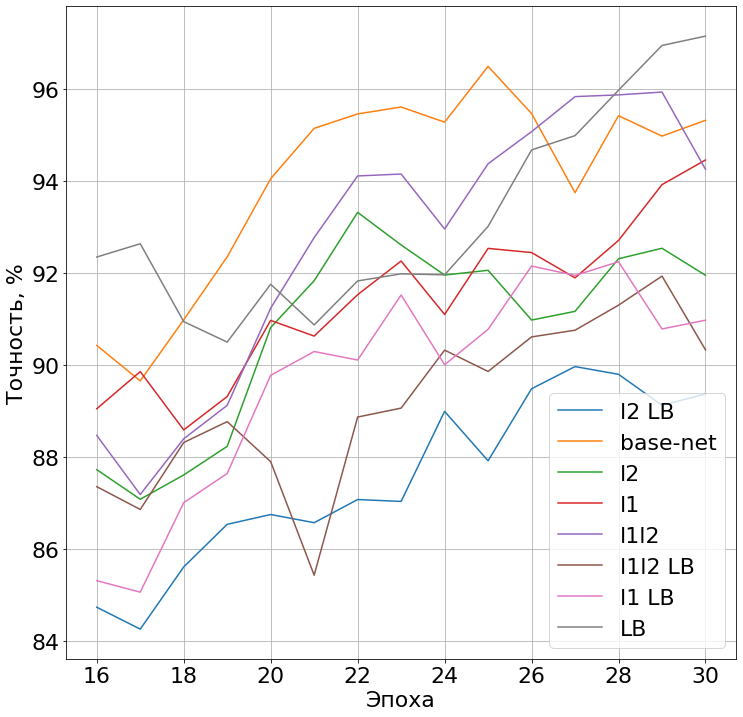

In [8]:
legends = []
fig = plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size': 22})

for net_name, result_dict in CONFIG_TO_RESULT.items():
    accuracy_np = result_dict[MEAN_VAL]
    accuracy_np = smooth_values(accuracy_np)[-15:]
    accuracy_np = np.asarray(accuracy_np)
    accuracy_np = np.clip(accuracy_np * 100.0 + MAGIC_SHIFT, 0, 100.0)
    plt.plot(range(16, 31), accuracy_np)
    name = ''
    if result_dict[CONFIG][L1_N]:
        name += 'l1'
    elif result_dict[CONFIG][L2_N]:
        name += 'l2'
    elif result_dict[CONFIG][L1_L2_N]:
        name += 'l1l2'
    
    if result_dict[CONFIG][LABEL_SMOOTHING]:
        if name == '':
            name = 'LB'
        else:
            name += ' LB'
    else:
        name += ''
    if name == '':
        name = 'base-net'
    legends.append(name)
plt.legend(legends)

plt.xlabel('Эпоха')
plt.ylabel('Точность, %')
plt.grid(True)

fig.savefig('mean_train_figure_last_15.png')
plt.show()